In [43]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import config as cfg
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler


CMR Features interesting for MAD

"MVP_new", "CMR_Largest_MAD","CMR_Degree_largest_MAD","CMR_MA_diam_sys","CMR_MA_diam_dia","TAD_presence",
"CMR_LV_mass","CMR_LV_EDV", "CMR_LV_ESV", "CMR_EF","CMR_LGE_Myocardium_percent","CMR_LGE_ANT_Pap_muscle",
"CMR_LGE_POST_Pap_muscle","CMR_max_ED_thickness_ineferolat_wall","CMR_max_ES_thickness_ineferolat_wall"


In [84]:
def load_patient_data(clinical_datapath):
    patientdata = pd.read_excel(clinical_datapath).drop([0,1])
    patientdata["Pat_no"] = patientdata["Pat_no"].astype(int)
    patientdata = patientdata.set_index("Pat_no")
    return patientdata

clinical_data = load_patient_data(cfg.CLINICAL_DATA_XL)

In [96]:
from kneed import KneeLocator
# feature = ["Aborted_cardiac_arrest","Ventricular_tachycardia","nsVT",
# "Mitral_regurg","Leaflet_thickness","MAD_presence","MAD_4CH_length",
#     "LVs_mass","EF","LA_Volume","CMR_LV_EDV","CMR_LV_ESV","CMR_ESV","CMR_EF","CMR_LGE_Myocardium_percent","CMR_LGE_ANT_Pap_muscle","CMR_LGE_POST_Pap_muscle","CMR_max_ED_thickness_ineferolat_wall",
#      "CMR_max_ES_thickness_ineferolat_wall"]
feature_lv = ["CMR_LV_mass","CMR_LV_EDV", "CMR_LV_ESV", "CMR_EF",
"CMR_max_ED_thickness_ineferolat_wall","CMR_max_ES_thickness_ineferolat_wall","LA_Volume",
"LVEDD","LVESD","LVPWd","IVSs"]
feature_mad = ["MVP_new", "CMR_Largest_MAD","CMR_Degree_largest_MAD","CMR_MA_diam_sys","CMR_MA_diam_dia","CMR_LGE_POST_Pap_muscle","CMR_max_ED_thickness_ineferolat_wall"]
# feature = ["Aborted_cardiac_arrest","Ventricular_tachycardia","nsVT","MVP_new", "CMR_Largest_MAD","CMR_Degree_largest_MAD","CMR_MA_diam_sys","CMR_MA_diam_dia","TAD_presence",
# "CMR_LV_mass","CMR_LV_EDV", "CMR_LV_ESV", "CMR_EF","CMR_LGE_Myocardium_percent","CMR_LGE_ANT_Pap_muscle",
# "CMR_LGE_POST_Pap_muscle","CMR_max_ED_thickness_ineferolat_wall","CMR_max_ES_thickness_ineferolat_wall","T_inv_inf_wall","Leaflet_thickness","LA_Volume","Mitral_regurg"
# ,"Mitral_stenosis","LVEDD","LVESD","LVPWd","IVSs","Prolapse_ESC_Y_N","Flail","Mitral_Annulus_systole","Mitral_Annulus_diastole","MAPSE_lat","GLS_LV","CMR_Degree_largest_MAD"]
feature = feature_lv
features = clinical_data[feature].fillna(0).to_numpy()
print(features.shape)


(155, 11)


In [97]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

In [ ]:


inertias = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(features)
    inertias.append(kmeans.inertia_)
plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()
    
kl = KneeLocator(range(1, 11), inertias, curve="convex", direction="decreasing")

kl.elbow


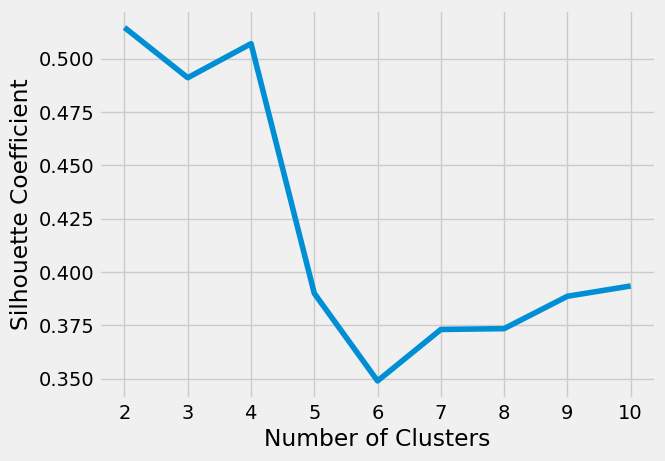

In [99]:
kmeans_kwargs = {
    "init": "k-means++",
   "n_init": 10,
   "max_iter": 300,
   "random_state": 42,
    }
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(features)
    score = silhouette_score(features, kmeans.labels_)
    silhouette_coefficients.append(score)
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

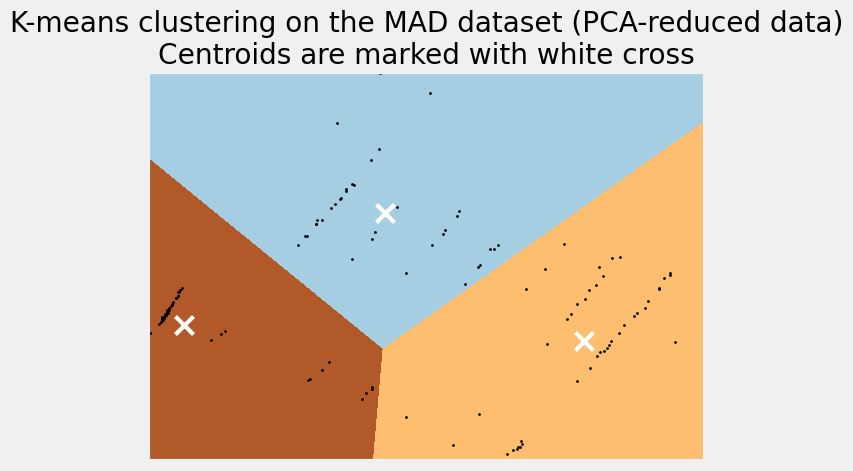

In [51]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(features)
kmeans = KMeans(init="k-means++", n_clusters=4, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the MAD dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

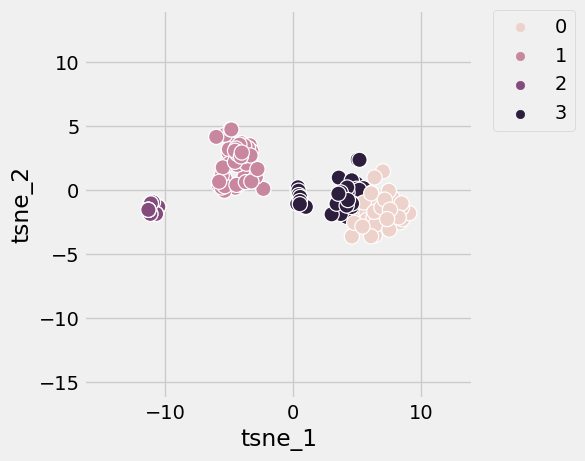

In [100]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

# Apply t-SNE to reduce the features to 2 dimensions
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
reduced_data = tsne.fit_transform(features)

# Apply KMeans clustering
kmeans = KMeans(init="k-means++", n_clusters=4, n_init=4) 
kmeans.fit(reduced_data)
tsne_result = reduced_data
y = [1,2]
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': kmeans.labels_})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


In [103]:
clinical_data['cluster_label'] = kmeans.labels_

# Number of clusters
num_clusters = 4

# Create a dictionary to hold data for all clusters
cluster_data = {}

for i in range(num_clusters):
    # Filter data for each cluster
    cluster_data[i] = clinical_data[clinical_data['cluster_label'] == i]

    # Display the first few rows of data for each cluster
    print(f"Data for cluster {i}:")
    print(cluster_data[i].head())



Data for cluster 0:
        ICD_incl  consent   BSA  Gender  age_inclusion  Weight  Height   BMI  \
Pat_no                                                                         
3            0.0      1.0  1.59     1.0           66.0    54.0    1.65  19.8   
8            0.0      NaN  1.97     0.0           45.0    75.0    1.83  22.4   
31           0.0      1.0  1.89     1.0           26.0    70.0    1.79  21.8   
35           0.0      1.0  1.81     0.0           63.0    62.0    1.83  18.5   
39           0.0      1.0  1.84     0.0           58.0    69.0    1.75  22.5   

        syst_BP  diast_BP  ...  Verapamil Aborted_cardiac_arrest.1  \
Pat_no                     ...                                       
3         147.0      91.0  ...        0.0                      0.0   
8         129.0      72.0  ...        NaN                      0.0   
31        109.0      75.0  ...        0.0                      0.0   
35        120.0      70.0  ...        0.0                      0.0   

In [110]:

average_feature_per_cluster = clinical_data.groupby('cluster_label')["Aborted_cardiac_arrest","Ventricular_tachycardia","nsVT",
"Mitral_regurg","Leaflet_thickness","MAD_presence","MAD_4CH_length",
    "LVs_mass","EF","LA_Volume","CMR_LV_EDV","CMR_LV_ESV","CMR_ESV","CMR_EF","CMR_LGE_Myocardium_percent","CMR_LGE_ANT_Pap_muscle","CMR_LGE_POST_Pap_muscle","CMR_max_ED_thickness_ineferolat_wall",
     "CMR_max_ES_thickness_ineferolat_wall"].mean()

# Display the result
print(average_feature_per_cluster)


               Aborted_cardiac_arrest  Ventricular_tachycardia      nsVT  \
cluster_label                                                              
0                            0.046512                 0.000000  0.236842   
1                            0.115385                 0.038462  0.270833   
2                            0.000000                 0.000000  0.000000   
3                            0.210526                 0.000000  0.222222   

               Mitral_regurg  Leaflet_thickness  MAD_presence  MAD_4CH_length  \
cluster_label                                                                   
0                   1.395349           3.558140      0.953488        4.674419   
1                   1.415094           3.671154      0.961538        4.622642   
2                        NaN                NaN      0.000000        0.000000   
3                   0.631579           3.000000      1.000000        4.432432   

                 LVs_mass         EF  LA_Volume  CMR_LV_

/var/folders/yw/xswvqj2x1ldf3fv5s9nl66z40000gn/T/ipykernel_6877/144110836.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  average_feature_per_cluster = clinical_data.groupby('cluster_label')["Aborted_cardiac_arrest","Ventricular_tachycardia","nsVT",
